In [1]:
import numpy as np
import pandas as pd
from DBEngine import db_engine
from DataService import get_annotated, normalize
import matplotlib.pyplot as plt

In [2]:
data = db_engine.execute(get_annotated)

df = pd.DataFrame(data, columns=["lat", "lon", "date", "brightness", "brightness_t31", "radiative_power", "dist_road", "dist_rail", "avg_population", "intent"])
df.head(10)

,lat,lon,date,brightness,brightness_t31,radiative_power,dist_road,dist_rail,avg_population,intent
0,31.8882,51.6665,2021-03-27,305.6,282.4,9.2,None,None,5.741589,1
1,32.2776,51.2285,2021-04-30,301.8,278.7,5.7,None,None,7.310967,1
2,28.1198,50.9087,2021-05-12,306.3,293.1,5.4,None,None,3.15715,1
3,32.238,46.9239,2021-08-22,319.8,301.7,7.4,None,None,12.057454,1
4,31.311,51.5166,2022-02-26,301.9,281.0,7.5,9.481799,None,556.319607,2
5,30.2457,50.5856,2022-02-26,302.7,278.6,7.9,34.25642,None,149.800956,2
6,30.1982,50.584,2022-02-26,351.8,281.9,73.4,180.934105,629.070528,135.22653,2
7,30.1873,50.5955,2022-02-26,343.8,282.6,56.1,328.244816,None,84.257003,2
8,30.2019,50.593,2022-02-26,320.7,280.8,21.5,98.55449,791.546167,84.635519,2
9,30.31,50.2298,2022-02-27,329.2,270.0,47.8,726.09937,1233.507614,23.282222,2


In [3]:
df = normalize(df)
df.head(10)

,lat,lon,date,brightness,brightness_t31,radiative_power,dist_road,dist_rail,avg_population,accident,attack
0,0.539216,0.911312,0.116598,0.066738,0.321408,0.006495,0,0,0.000957,1,0
1,0.560757,0.856487,0.163237,0.042813,0.294448,0.004024,0,0,0.001237,1,0
2,0.33076,0.816457,0.179698,0.071145,0.399373,0.003813,0,0,0.000495,1,0
3,0.558566,0.317675,0.319616,0.156142,0.462037,0.005225,0,0,0.002085,1,0
4,0.507288,0.892549,0.577503,0.043443,0.311207,0.005295,0.909538,0,0.099326,0,1
5,0.448358,0.776014,0.577503,0.04848,0.293719,0.005578,0.709948,0,0.026695,0,1
6,0.445731,0.775814,0.577503,0.357615,0.317765,0.051823,0.163762,0.001853,0.024092,0,1
7,0.445128,0.777254,0.577503,0.307247,0.322865,0.039608,0.037536,0,0.014985,0,1
8,0.445935,0.776941,0.577503,0.161808,0.309749,0.01518,0.373236,0.000365,0.015053,0,1
9,0.451915,0.731479,0.578875,0.215325,0.231055,0.033748,0.000702,0.000004,0.004091,0,1


In [4]:
validation_df = df.sample(n=2048)
df.drop(validation_df.index, inplace=True)
test_df = df.sample(n=2048)
df.drop(test_df.index, inplace=True)

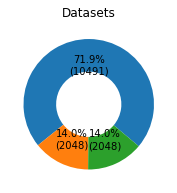

In [5]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["Train", "Validate", "Test"]
data = [len(df), len(validation_df), len(test_df)]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40, autopct=lambda pct: func(pct, data))

ax.set_title("Datasets")

plt.show()

In [6]:
import torch
from torch import nn
from NeuralNetwork import NeuralNet, device

model = NeuralNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)

NeuralNet(
  (f_connected1): Linear(in_features=9, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)


In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

def dataFrameToDataLoader(df: pd.DataFrame, batch_size: int) -> DataLoader:
  X = df.to_numpy()[:, :-2]
  y = df.to_numpy()[:, -2:]

  ds = TensorDataset(
    torch.tensor(X.astype('float64'), dtype=torch.float),
    torch.tensor(y.astype('float64'), dtype=torch.float)
  )

  return DataLoader(ds, batch_size=batch_size)

In [8]:
train_dl = dataFrameToDataLoader(df, 256)
validation_dl = dataFrameToDataLoader(validation_df, 64)

In [9]:
epoch = 0
validation_ce = 0
last_validation_ce = 0

while (epoch < 10 or last_validation_ce > validation_ce):
  epoch += 1
  last_validation_ce = validation_ce

  train_ce = model.iter_train(train_dl, loss_fn, optimizer)
  validation_ce = model.iter_validate(validation_dl, loss_fn)
  print(f"Epoch {epoch}: Train loss: {train_ce}, Validation loss: {validation_ce}")

Epoch 1: Train loss: 0.9325042541434125, Validation loss: 0.6896911207586527
Epoch 2: Train loss: 0.6963111118572515, Validation loss: 0.6381336469203234
Epoch 3: Train loss: 0.7656600417160406, Validation loss: 0.6439351700246334
Epoch 4: Train loss: 0.6613535597556974, Validation loss: 0.5786243956536055
Epoch 5: Train loss: 0.6845882033429495, Validation loss: 0.5478052757680416
Epoch 6: Train loss: 0.615792295918232, Validation loss: 0.49999802839010954
Epoch 7: Train loss: 0.5954132527112961, Validation loss: 0.44471384212374687
Epoch 8: Train loss: 0.533839328805121, Validation loss: 0.39210419449955225
Epoch 9: Train loss: 0.4780592176972366, Validation loss: 0.34216134855523705
Epoch 10: Train loss: 0.4270295528013532, Validation loss: 0.2834914093837142
Epoch 11: Train loss: 0.35491558709522575, Validation loss: 0.24626353662461042
Epoch 12: Train loss: 0.3143314254901758, Validation loss: 0.20088954898528755
Epoch 13: Train loss: 0.2664404645471311, Validation loss: 0.1706579

In [10]:
test_X = test_df.to_numpy()[:, :-2]
test_y = test_df.to_numpy()[:, -2:]

prediction_dataset = TensorDataset(
  torch.tensor(test_X.astype('float64'), dtype=torch.float)
)

predicted = model.predict(prediction_dataset)
classes = predicted[0].detach().numpy()

classes = classes[:, 0] - classes[:, 1] > 0
test_y = test_y[:, 0] - test_y[:, 1] > 0
result = classes == test_y
sum(result) / len(test_df)

1.0

In [11]:
model.save('./firms.pt')